In [1]:
try:
    import pulser
except ModuleNotFoundError:
    import sys
    sys.path.insert(1, '../')

In [2]:
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

from pulser import Pulse, Sequence, Register
from pulser.devices import Chadoq2
import pulser.waveforms as waveforms

# 1. Layer-based sequences

We shall implement a version of Variational Quantum Simulation, following https://arxiv.org/pdf/1810.03421 .

First we set up our atom array

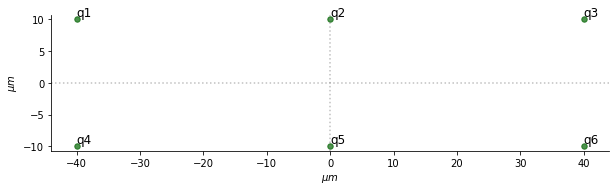

In [3]:
# How many qubits (MxN):
M = 2 #vert
N = 3 #horiz

# Rectangle dimensions to place qubits:
L_horiz = 80
L_vert = 20

coords = np.array([[j,-i] for i in np.linspace(0,L_vert,M) for j in np.linspace(0,L_horiz,N)])
coords -= np.mean(coords,axis=0)

qubits = {}
for i, coord in enumerate(coords,1):
    qubits[f"q{i}"] = coord

reg = Register(qubits)
reg.draw()

Next, we select our device and we declare the channels that we will be using

In [1127]:
device = Chadoq2(qubits)
seq = Sequence(device) # Resets if called again
pprint(seq.available_channels)

seq.declare_channel('ryd', 'rydberg_global') # We shall be acting on all the atoms
pprint(seq.declared_channels)

{'raman_local': Raman(local, Max Absolute Detuning: 50 MHz, Max Amplitude: 10 MHz, Target time: 100 ns, Basis: 'digital'),
 'rydberg_global': Rydberg(global, Max Absolute Detuning: 50 MHz, Max Amplitude: 2.5 MHz, Basis: 'ground-rydberg'),
 'rydberg_local': Rydberg(local, Max Absolute Detuning: 50 MHz, Max Amplitude: 10 MHz, Target time: 100 ns, Basis: 'ground-rydberg'),
 'rydberg_local2': Rydberg(local, Max Absolute Detuning: 50 MHz, Max Amplitude: 10 MHz, Target time: 100 ns, Basis: 'ground-rydberg')}
{'ryd': Rydberg(global, Max Absolute Detuning: 50 MHz, Max Amplitude: 2.5 MHz, Basis: 'ground-rydberg')}


Create some waveforms to construct pulses

In [1128]:
gaussian = waveforms.GaussianWaveform(1000,4,250) #duration=100, max_ampl=2, stdev=150
ramp = waveforms.RampWaveform(gaussian.duration, -20, 20)  # Duration: 1000ns, linear sweep from -20 to 20 MHz

Create the layers of the circuit as pulse sequences

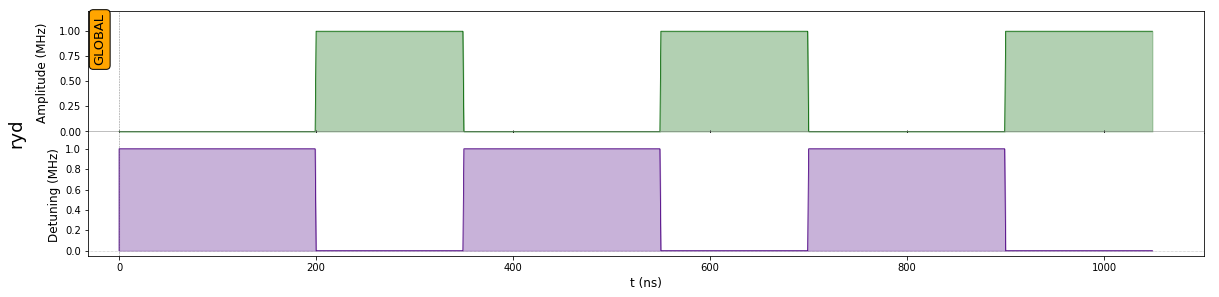

In [1129]:
layers = 3

cost = Pulse.ConstantPulse(150, 1, 0, 0)

#seq = Sequence(device) # Resets sequence every time its called
#seq.declare_channel('ryd', 'rydberg_global') # We shall be acting on all the atoms

mix = Pulse.ConstantPulse(200, 0, 1, 0)

for _ in range(layers):
    seq.add(mix, 'ryd')
    seq.add(cost, 'ryd')

seq.draw()

# 2. Emulating a run of the sequence

First we create the Qobjs that represent the Quantum Resource

In [1130]:
# Some useful functions:

def get_dist(a,b):
    """
    Returns the distance r_ij between qubits i and j.
    Recall a and b can be strings like 'q4', etc.
    """
    x = qubits[a]
    y = qubits[b]
    return np.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2 )

In [1158]:
import qutip


# Global variable for generating tensor product of identities
ones = [qutip.qeye(2) for _ in range(N*M)]

#Global dictionary of operators:
gates = {'paulix' : qutip.sigmax(),
         'pauliy' : qutip.sigmay(),
         'pauliz' : qutip.sigmaz(),
         'occup' : 0.5 * (1+qutip.sigmaz()) }

def get_neighbors(qubit_id, N, M):
    """
    returns the labels of the nearest neighbors of a qubit ID, with open boundary conditions
    """
    i = int(qubit_id[1:])
    if M == 1: # 1D array:
        if i == 1:
            return([f'q2'])
        elif i == N:
            return([f'q{N-1}'])
        else:
            return([f'q{i-1}',f'q{i+1}'])
                    
    else: #2D array
        if i == 1:
            return([f'q2', f'q{(N+1)}'])
        elif i == N:
            return([f'q{N-1}',f'q{2*N}'])
        elif i == (M-1)*N + 1:
            return([f'q{(M-2)*N+1}',f'q{(M-1)*N+2}'])
        elif i == M*N:
            return([f'q{M*N-1}',f'q{(M-1)*N}'])
        elif i < N:
            return([f'q{i-1}',f'q{i+1}',f'q{N+i}'])
        elif i % N == 1:
            return([f'q{i-N}',f'q{i+N}',f'q{i+1}'])
        elif i % N == 0:
            return([f'q{i-N}',f'q{i+N}',f'q{i-1}'])
        elif i > (M-1)*N + 1:
            return([f'q{i+1}', f'q{i-1}',f'q{i-N}'])
        else:
            return([f'q{i-1}',f'q{i+1}',f'q{i+N}',f'q{i-N}'])

def local_operator(qubit_id,name):
    """
    Returns a local gate at a qubit
    """
    temp = ones.copy()
    pos = int(qubit_id[1:]) - 1 #so that it runs from 0 to N*M-1
    temp[pos] = gates[name]
    return qutip.tensor(temp)

def two_body_operator(qubit_id1, qubit_id2, name):
    """
    Returns a local gate at a qubit
    """
    temp = ones.copy()
    pos1 = int(qubit_id1[1:]) - 1 #so that it runs from 0 to N*M-1
    pos2 = int(qubit_id2[1:]) - 1 #so that it runs from 0 to N*M-1
    temp[pos1] = gates[name]
    temp[pos2] = gates[name]
    return qutip.tensor(temp)

In [1189]:
# Sum of sigma x:

H_X = 0 # Time-dependent
for qubit in qubits:
    H_X += local_operator(qubit,'paulix')
    
# Sum of occupations:

H_N = 0 # Time-dependent
for qubit in qubits:
    H_N -= local_operator(qubit,'occup')
    
# Sum of Neighbors:
H_NN = 0 # Time-independent
C6 = 1e10
for qubit in qubits:
    for qubit2 in qubits:
        if qubit < qubit2:
            R = get_dist(qubit,qubit2)
            coupling = C6/R**6
            H_NN += coupling * two_body_operator(qubit,qubit2,'occup')

            print(qubit,qubit2, coupling)

q1 q2 27.809143066406243
q1 q3 0.43451786041259755
q1 q4 0.03814697265625
q2 q3 27.809143066406243
q2 q4 0.4345178604125979
q3 q4 27.809143066406264


Now we want to extract the contents of the sequences into the qubits, as instructions for emulation in qutip

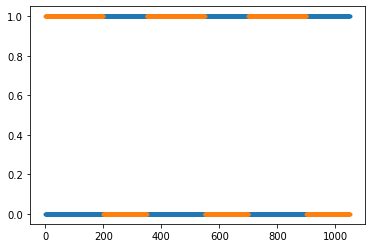

In [1190]:
# Get Rabi freq and detuning samples from all sequence

amp = []
det = []
for x in seq._schedule['ryd']:
    obj = x.type
    if type(obj) == Pulse:
        #absolute_time = np.arange(x.ti,x.tf) #absolute time tags from ti to tf of each sequence block
        #print(alsolute_time)
        relative_time = range(obj.duration) # relative time to sequence block
        
        for t in relative_time: 
            amp.append(obj.amplitude.samples[t])
            det.append(obj.detuning.samples[t])

plt.plot(range(len(amp)),amp,'.')
plt.plot(range(len(det)),det,'.')

In [1191]:
#Observable and Initial State
observable = local_operator("q1",'occup') + two_body_operator('q1','q3','occup')
psi0 = qutip.tensor([qutip.basis(2, 0) for _ in range(N*M)]) # all up

# Observable (usually diagonal)
observable = 0
for i in range(N*M):
    observable += local_operator(f"q{i+1}",'occup')

for i in range(N*M):
    nn = get_neighbors(f"q{i+1}",N,M)
    for qubit in nn:
        if i<int(qubit[1:]): # only consider once each pair
            observable += two_body_operator(f"q{i+1}",qubit,"occup")
            #print(f"q{i+1}",qubit)


# Initial State (hadarmard)
all_down = [qutip.basis(2,1) for _ in range(N*M)]
psi0 = 0
for k in range(N*M):
    temporary = all_down.copy()
    temporary[k] = qutip.basis(2,0)
    psi0 += (1/np.sqrt(2))**(N*M) * qutip.tensor(temporary)

In [1192]:
# Callables for time evolution
def omega (t,args):
    return amp[int(t)]

def delta (t,args):
    return det[int(t)]


H = [H_NN, [H_N, delta], [H_X, omega]]

total_duration = max([seq._last(ch).tf for ch in seq._schedule])
output = qutip.sesolve(H, psi0, range(total_duration), [observable])

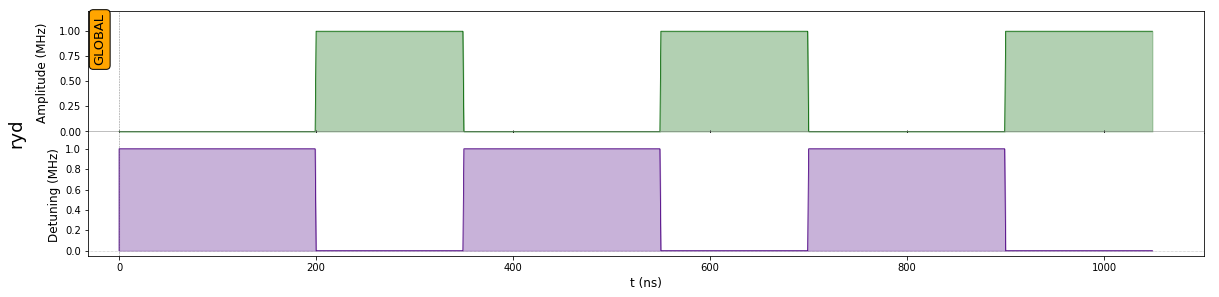

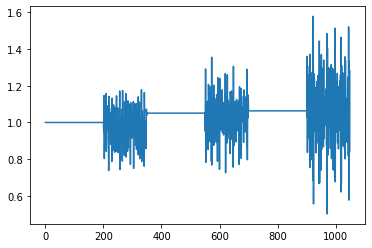

In [1193]:
seq.draw()
plt.plot(range(total_duration),output.expect[0])

# Putting Everything into a function

We want to parametrize this routine. Define atom array:

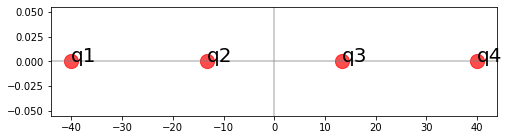

In [1318]:
# How many qubits (MxN):
M = 1 #vert
N = 4 #horiz

# Rectangle dimensions to place qubits:
L_horiz = 80
L_vert = 20

coords = np.array([[j,-i] for i in np.linspace(0,L_vert,M) for j in np.linspace(0,L_horiz,N)])
coords -= np.mean(coords,axis=0)

qubits = {}
for i, coord in enumerate(coords,1):
    qubits[f"q{i}"] = coord


# Plot atom array:
#print(qubits)
fig, ax = plt.subplots(figsize=(L_horiz/10, L_vert/10))
ax.scatter(coords[:,0],coords[:,1],s=200,alpha=0.7,c='r')
ax.axvline(0,c='grey',alpha=0.5)
ax.axhline(0,c='grey',alpha=0.5)

for q in qubits:
    ax.annotate(q, (qubits[q][0], qubits[q][1]),fontsize=20)

plt.show()

In [1319]:
# Global variable for generating tensor product of identities
ones = [qutip.qeye(2) for _ in range(N*M)]

#Global dictionary of operators:
gates = {'paulix' : qutip.sigmax(),
         'pauliy' : qutip.sigmay(),
         'pauliz' : qutip.sigmaz(),
         'occup' : 0.5 * (1+qutip.sigmaz()) }

We define our Global Variables and the Initial State

In [1320]:
# Observable (usually diagonal)
observable = 0
for i in range(N*M):
    observable += local_operator(f"q{i+1}",'occup')

for i in range(N*M):
    nn = get_neighbors(f"q{i+1}",N,M)
    for qubit in nn:
        if i<int(qubit[1:]): # only consider once each pair
            observable += two_body_operator(f"q{i+1}",qubit,"occup")
            #print(f"q{i+1}",qubit)


# Initial State (hadarmard)
all_down = [qutip.basis(2,0) for _ in range(N*M)]
psi0 = 0
for k in range(N*M):
    temporary = all_down.copy()
    temporary[k] = qutip.basis(2,1)
    psi0 += (1/np.sqrt(2))**(N*M) * qutip.tensor(temporary)

In [1321]:
psi0

Quantum object: dims = [[2, 2, 2, 2], [1, 1, 1, 1]], shape = (16, 1), type = ket
Qobj data =
[[0.  ]
 [0.25]
 [0.25]
 [0.  ]
 [0.25]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.25]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]]

Build Resource Hamiltonian:

\begin{align}
\mathcal H_R = \Omega(t) \sum_i \sigma_i^x + \delta(t) \sum_i n_i + \sum_{i<j} \frac{C_6}{R_{ij}^6} n_in_j
\end{align}

Detuning drives (diagonal) evolution that commutes with Z. Amplitude drives non-commuting (mixing) evolution

In [1334]:
# Sum of sigma x:
H_X = 0 # Time-dependent (Rabi Frequency)
for qubit in qubits:
    H_X += local_operator(qubit,'paulix')
    
# Sum of occupations:
H_N = 0 # Time-dependent (Detuning)
for qubit in qubits:
    H_N -= local_operator(qubit,'occup') # Notice the minus sign (bias towards all up)
    
# Sum of Neighbors:
H_NN = 0 # Time-independent
C6 = 1e8 # Gives 1 for nearest neighbors, 0.015 for nnn and so on
for qubit in qubits:
    for qubit2 in qubits:
        if qubit < qubit2:
            R = get_dist(qubit,qubit2)
            coupling = C6/R**6
            H_NN += coupling * two_body_operator(qubit,qubit2,'occup')
            print(coupling)


0.27809143066406244
0.004345178604125976
0.0003814697265625
0.27809143066406244
0.004345178604125979
0.27809143066406267


Define a Cost Function

In [1338]:
# Sequence based on Constant Pulses and variable durations
evol = lambda duration: Pulse.ConstantPulse(duration, 0, 4, 0)
mix = lambda duration: Pulse.ConstantPulse(duration, 0.2, 0, 0)

#psi0 = qutip.tensor(all_down)

def cost_function(params, draw=False):

    seq = Sequence(device) # Resets sequence every time its called
    seq.declare_channel('ryd', 'rydberg_global') # We shall be acting on all the atoms

    for p in range(layers):
        seq.add(evol(params[0][p]), 'ryd') #amplitude
        seq.add(mix(params[1][p]), 'ryd') #detuning   
        
          
        
    if draw: seq.draw()
    total_duration = max([seq._last(ch).tf for ch in seq._schedule])
    
    amp = []
    det = []
    
    #Get pulse sequence
    for x in seq._schedule['ryd']:
        block = x.type
        if type(block) == Pulse:
            for t in range(block.duration): # Add samples 
                det.append(block.detuning.samples[t])
                amp.append(block.amplitude.samples[t])

    # Callables for time evolution
    delta = lambda t,args: det[int(t)]
    omega = lambda t,args: amp[int(t)]

    H = [H_NN, [H_N, delta], [H_X, omega]]

    
    output = qutip.sesolve(H, psi0 , range(total_duration), [observable])
    return(output.expect[0][-1]) #return final (in time) expectation value

Test some layers with random durations:

[[75]
 [54]]


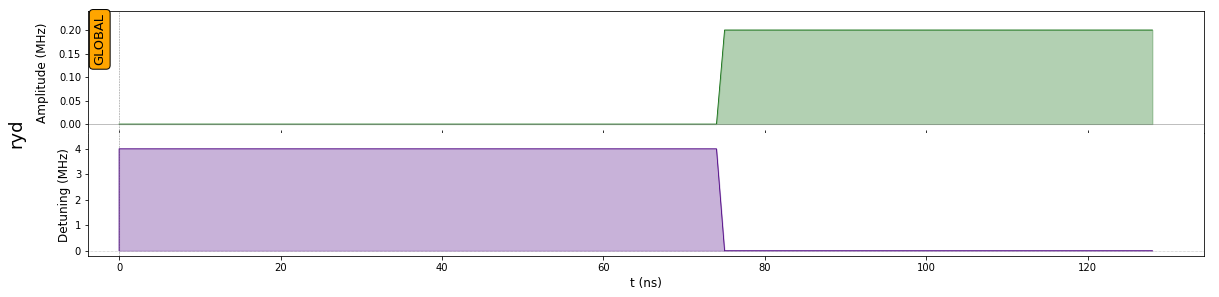

3.4079827748909843


In [1339]:
np.random.seed(5)

layers = 1
params = np.random.randint(40,100,size=(2,layers))

print(params)
print(cost_function(params, draw=True))

Check some parameter space at depth 1:

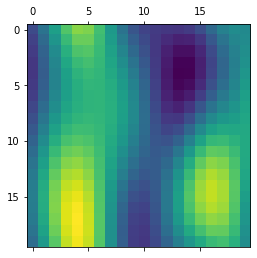

In [1341]:
layers = 1
K = 20
results = np.zeros((K,K))

for theta1 in range(K):
    for theta2 in range(K):
        params = [[10+theta1],[10+theta2]]
        results[theta1,theta2] = cost_function(params)
        #print(params, results[theta1,theta2])
        
plt.matshow(results)

Optimize Parameters in a proper region

In [ ]:
scipy.optimize.minimize(cost_function, )